In [10]:
#Import libraries
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [11]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [12]:
#Set variables
fsym = 'ADA' #crypto currency symbol
sym = 'EUR' #price currency
limit = '2000' #amount price points

test_size = 0.1

prediction_days = 30

In [13]:
#Get data
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=' + fsym + '&tsym=' + sym + '&limit=' + limit)
org_data = pd.DataFrame(json.loads(res.content)['Data'])

In [14]:
data, test_data = train_test_split(org_data, test_size=test_size)

### Prepare Data

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Build the model

In [16]:
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mean_squared_error'
dropout = 0.2
optimizer = 'adam'
units = 50

In [17]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(input_data.shape[1],1)))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    
    model.compile(optimizer=optimizer, loss=loss)

    return model

In [9]:
model = build_lstm_model(x_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

NameError: name 'Activation' is not defined

### Test the mode accuracy on exiting data

In [229]:
actual_prices = test_data['close'].values

total_dataset = pd.concat((data['close'], test_data['close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

# make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

### Plot test test predictions

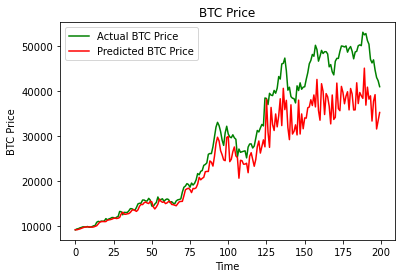

In [230]:
plt.plot(actual_prices, color='green', label=f"Actual {fsym} Price")
plt.plot(predicted_prices, color='red', label=f"Predicted {fsym} Price")
plt.title(f"{fsym} Price")
plt.xlabel('Time')
plt.ylabel(f"{fsym} Price")
plt.legend()
plt.show()

### Predict next day

In [231]:
real_data_org = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs + 1), 0]]
real_data = real_data_org
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f"Prediction: {prediction}")

Prediction: [[32158.248]]
